In [1]:
import osmnx as ox
import networkx as nx
from matplotlib import pyplot as plt
import gdal
import rasterio

# Define the place name
place_name = "Uniontown, Alabama, USA"

# Download the street network for the specified place
G = ox.graph_from_place(place_name, network_type='drive')

# Optionally, you can simplify the graph
# G = ox.simplify_graph(G)

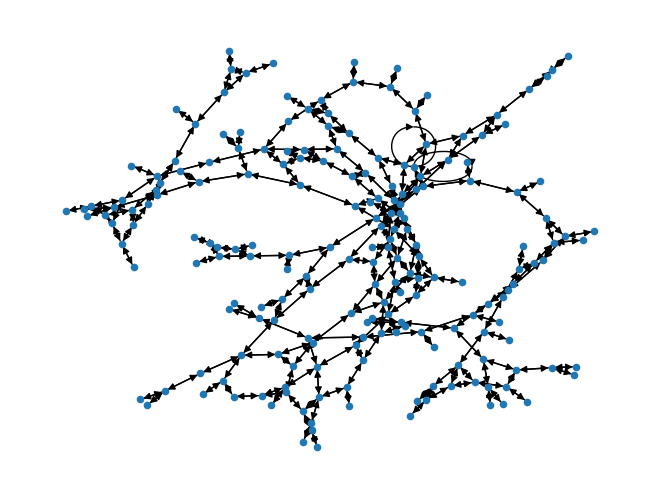

In [11]:
nx.draw(G, with_labels=False, node_size=20)

Number of nodes: 199
Number of edges: 506


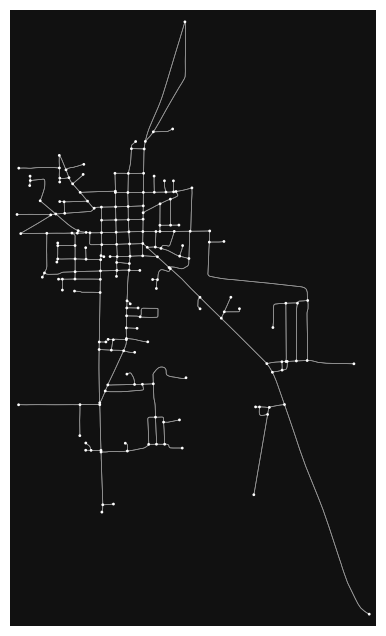

In [2]:

# Print some basic statistics about the graph
print(f"Number of nodes: {len(G.nodes)}")
print(f"Number of edges: {len(G.edges)}")

# Plot the graph
fig, ax = ox.plot_graph(G, node_size=4, edge_linewidth=0.5)

In [7]:
G = ox.elevation.add_node_elevations_raster(G, filepath='C:\\Users\mbans\Desktop\CMOR492-DWS\DWS\\Uniontown.tif', cpus=None)

ImportError: gdal and rasterio must be installed to query raster files

In [2]:
import geopandas as gpd

In [3]:
# Download building footprints
buildings = ox.geometries_from_place(place_name, tags={'building': True})

# Convert buildings to a GeoDataFrame
buildings_gdf = gpd.GeoDataFrame(buildings)

C:\Users\mbans\AppData\Local\Temp\ipykernel_8468\1149224087.py:2: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  buildings = ox.geometries_from_place(place_name, tags={'building': True})


In [4]:
# Ensure 'osmid' is included in the GeoDataFrame
if 'osmid' not in buildings_gdf.columns:
    buildings_gdf['osmid'] = buildings_gdf.index

In [5]:

# Add buildings as nodes to the graph
for _, building in buildings_gdf.iterrows():
    # Get the centroid of the building
    centroid = building['geometry'].centroid
    # Add the building as a node to the graph
    G.add_node(building['osmid'], x=centroid.x, y=centroid.y, building=building['building'])

Number of nodes: 1828
Number of edges: 506


<Axes: >

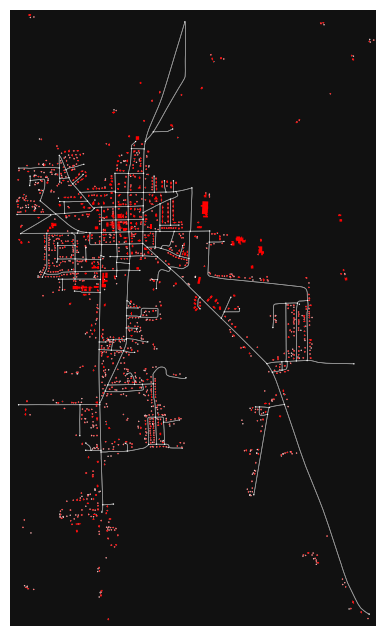

In [6]:
# Print some basic statistics about the graph
print(f"Number of nodes: {len(G.nodes)}")
print(f"Number of edges: {len(G.edges)}")

# Plot the graph with buildings
fig, ax = ox.plot_graph(G, node_size=1, edge_linewidth=0.5, show=False, close=False)
buildings_gdf.plot(ax=ax, color='red', markersize=5)

In [38]:
from sklearn.cluster import DBSCAN
import numpy as np

In [41]:
# Extract the centroids of the buildings
centroids = buildings_gdf.geometry.centroid

C:\Users\mbans\AppData\Local\Temp\ipykernel_6800\838735184.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = buildings_gdf.geometry.centroid


In [51]:
# Convert centroids to a NumPy array for clustering
coords = np.array([(point.x, point.y) for point in centroids])

# Use DBSCAN to cluster the buildings
db = DBSCAN(eps=.00005, min_samples=2).fit(coords)  # Adjust eps and min_samples as needed
labels = db.labels_

# Add a 'cluster' column to the buildings GeoDataFrame
buildings_gdf['cluster'] = labels

In [52]:
# Create a new node for each cluster and connect it to the road network
for cluster_id in np.unique(labels):
    if cluster_id == -1:
        continue  # Skip noise points

    # Get the buildings in the current cluster
    cluster_buildings = buildings_gdf[buildings_gdf['cluster'] == cluster_id]

    # Calculate the centroid of the cluster
    cluster_centroid = cluster_buildings.geometry.unary_union.centroid

    # Add the cluster centroid as a new node to the graph
    cluster_node_id = f"cluster_{cluster_id}"
    G.add_node(cluster_node_id, x=cluster_centroid.x, y=cluster_centroid.y, building='cluster')

    # Find the nearest road node
    nearest_road_node = ox.distance.nearest_nodes(G, cluster_centroid.x, cluster_centroid.y)

    # Add an edge connecting the cluster centroid to the nearest road node
    G.add_edge(cluster_node_id, nearest_road_node, length=ox.distance.euclidean_dist_vec(
        cluster_centroid.x, cluster_centroid.y,
        G.nodes[nearest_road_node]['x'], G.nodes[nearest_road_node]['y']
    ))

Number of nodes: 862
Number of edges: 232


C:\Users\mbans\AppData\Local\Temp\ipykernel_6800\294299718.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cluster_centroids = buildings_gdf.dissolve(by='cluster').geometry.centroid


<Axes: >

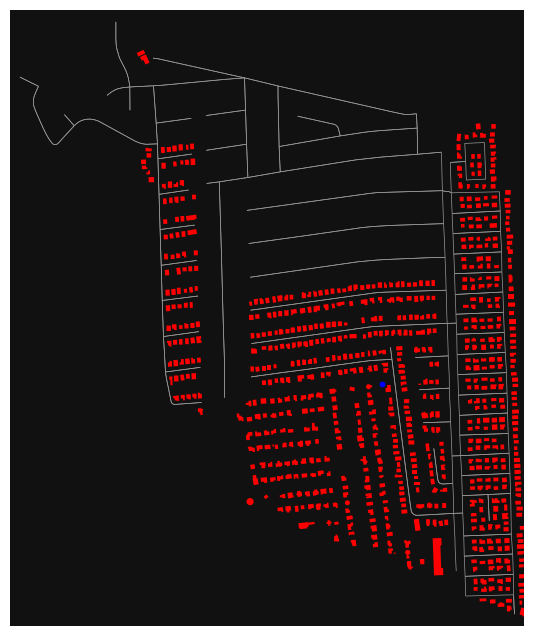

In [53]:
# Print some basic statistics about the graph
print(f"Number of nodes: {len(G.nodes)}")
print(f"Number of edges: {len(G.edges)}")

# Plot the graph with buildings and clusters
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5, show=False, close=False)
buildings_gdf.plot(ax=ax, color='red', markersize=5)
cluster_centroids = buildings_gdf.dissolve(by='cluster').geometry.centroid
cluster_centroids.plot(ax=ax, color='blue', markersize=10)